#2η ομαδική άσκηση στη Τεχνολογία και Ανάλυση Εικόνων και Βίντεο

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data()

In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα δουλεψε με διαφορετικό υποσύνολο του dataset.
Στο επόμενο κελί, αντικαταστήσαμε την τιμή της μεταβλητής `team_seed` με τον αριθμό που αντιστοιχεί στην ομάδας μας. 

In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 24

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' bottle', ' bowl', ' bus', ' caterpillar', ' chimpanzee', ' clock', ' cockroach', ' hamster', ' lamp', ' man', ' motorcycle', ' mushroom', ' pickup_truck', ' rabbit', ' road', ' seal', ' shrew', ' skyscraper', ' snake', ' sunflower']


In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


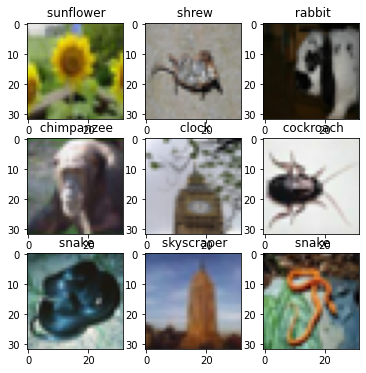

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Διαχείριση μνήμης (TFRecord)
Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούνα να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).


In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object




## Ερώτημα 1

#### Βήμα 1: Σχεδίαση, μεταγλώττιση και εκπαίδευση των μοντέλων



1.1.  Σχεδιασμός των ακόλουθων μοντέλων:

  1.   **Softmax (baseline)**: FC(200), SOFTMAX

  2.   **MLP**: FC(512), RELU, FC(200), SOFTMAX

  3.   **LeNet**: CONV(32, 3), RELU, POOL(2), CONV(32,3), RELU, POOL(2), FC(512, RELU, FC(200),SOFTMAX

  4. **CNN1**: CONV(16, 5), RELU, POOL(2), CONV(16,3), RELU, POOL(2), CONV(32, 3), RELU, FC(200), SOFTMAX

  5. **CNN2** 
  

1.2.  Μεταγλωττιση και εκπαιδεύση  όλων των μοντέλων, χρησιμοποιώντας 2 διαφορετικούς (καλύτερους) συνδυασμούς optimizer, loss, metrics και epoch (θα προκύψουν 10 διαφορετικά εκπαιδευμένα μοντέλα, 2 ανά αρχιτεκτονική). 

---

#### Βήμα 2: Αξιολόγηση των μοντέλων

2.1. Για κάθε ένα από τα μοντέλα που εκπαιδεύσαμε, απεικονίση σε κοινό διάγραμμα της ακρίβειας εκπαίδευσης και της ακρίβεια επικύρωσης στο σύνολο των εποχών, για κάθε διαφορετικό συνδυασμό του βήματος 1.2 (10 διαγράμματα) και επιλογή αυτού με την καλύτερη ακρίβεια από κάθε μοντέλο (ένα από κάθε αρχιτεκτονική, συνολικά 5).


2.2. Για κάθε ένα από τα μοντέλα με την καλύτερη ακρίβεια(συνολικά 5), απεικονίση σε κοινό διάγραμμα της ακρίβειας εκπαίδευσης και της ακρίβεια επικύρωσης στο σύνολο των εποχών.


2.3. Αναλυτική αξιολόγηση των αποτελεσμάτων ως προς:

 - Επίδραση του πλήθους των δεδομένων/κλάσεων στην απόδοση του μοντέλου
 - Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)
 - Επίδραση του μεγέθους δέσμης (batch size)
 
---

#### Βήμα 3

Αξιολογήση της ακρίβεια για το test set μας.


In [ ]:
# Βήμα 1
# 1.1 Σχεδιασμός των ζητούμενων μοντέλων
# 1.2 Μεταγλώτιση και εκπαίδευση των μοντέλων  χρησιμοποιώντας 2 διαφορετικούς (καλύτερους) συνδυασμούς optimizer, loss, metrics και epoch 

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import tensorflow.keras

#αφού δοκιμάσαμε τους περισσοτερους optimizers διαπιστωσαμε οτι αυτοι για τους οποιούς περναμε το καλύτερο αποτέλεσμα 
# (με βάση την τιμή της μετρικής accuracy )
# ήταν οι Adam (Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments)
# και Adagrad (Adagrad is an optimizer with parameter-specific learning rates, 
# which are adapted relative to how frequently a parameter gets updated during training).
# Η μετρική που επιλέξαμε ήταν το accuracy,που χρησιμοποιήθηκε και στα παραδείγματα
# των notebooks που διδάχτηκαν.
# Επίσης καθώς έχουμε προβλημα πολλών κλάσεων με single-label classification
# και activation στο τελευταίο επίπεδο softmax
# η ιδανικότερη loss function είναι η sparse_categorical_crossentropy
# όπως προέκυψε από σχετικές αναζητήσεις

#Softmax (baseline): FC(200), SOFTMAX

def Softmax(summary,version):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200,activation='softmax'))
  if version=='1':
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  else:
   model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  return model


In [ ]:
Softmax1=Softmax(True,1)

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_72 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Softmax2=Softmax(True,1)

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_73 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#MLP: FC(512), RELU, FC(200), SOFTMAX

def MLP(summary,version):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  if version=='1':
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  else:
   model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  return model


In [ ]:
MLP1=MLP(True,1)

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_74 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_99 (Dense)             (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MLP2=MLP(True,2)

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_75 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_101 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#LeNet: CONV(32, 3), RELU, POOL(2), CONV(32,3), RELU, POOL(2), FC(512, RELU, FC(200),SOFTMAX

def LeNet(summary,version):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  if version=='1':
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  else :
    model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model


In [ ]:
Lenet1=LeNet(summary=True,version=1)

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_76 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               590336    
_________________________________________________________________
dense_103 (Dense)            (None, 200)             

In [ ]:
LeNet2=LeNet(summary=True,version=2)

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_77 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 512)               590336    
_________________________________________________________________
dense_105 (Dense)            (None, 200)             

In [ ]:
#CNN: CONV(16, 5), RELU, POOL(2), CONV(16,3), RELU, POOL(2), CONV(32, 3), RELU, FC(200), SOFTMAX

def CNN(summary,version):
    
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(200,activation='softmax'))
  
  if version=='1':
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  else:
    model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])    
  if summary: 
    model.summary()
  return model

In [ ]:
CNN1=CNN(summary=True,version=1)

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_78 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 200)             

In [ ]:
CNN2=CNN(summary=True,version=2)

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_79 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 200)             

In [ ]:
#MYCNN
def MYCNN(summary,version):
   model = models.Sequential()
   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.Flatten())
   model.add(layers.Dense(100,activation='relu'))
   if version=='1':
     model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
   else:
    model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])    
   if summary: 
    model.summary()
   return model

In [ ]:
MYCNN1=MYCNN(summary=True,version=1)

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_80 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_108 (Dense)            (None, 100)             

In [ ]:
MYCNN2=MYCNN(summary=True,version=2)

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_110 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_143 (Dense)            (None, 100)            

In [ ]:
# δημιουργία βοηθητικής συνάρτησης
# για την εκπαίδευση των μοντέλων που δημιουργήσαμε
def train_model(model, epochs , steps_per_epoch , validation_steps ):
  
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

In [ ]:
train_Softmax1=train_model(Softmax1,30,100,5)

Epoch 1/30
100/100 [==============================] - 1s 12ms/step - loss: 3.6460 - accuracy: 0.0870 - val_loss: 3.1047 - val_accuracy: 0.1187
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 2.9895 - accuracy: 0.1545 - val_loss: 2.9154 - val_accuracy: 0.1828
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 2.8419 - accuracy: 0.2008 - val_loss: 2.7774 - val_accuracy: 0.2016
Epoch 4/30
100/100 [==============================] - 1s 13ms/step - loss: 2.7572 - accuracy: 0.2304 - val_loss: 2.7032 - val_accuracy: 0.2328
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 2.6944 - accuracy: 0.2409 - val_loss: 2.6850 - val_accuracy: 0.2266
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 2.6420 - accuracy: 0.2571 - val_loss: 2.5933 - val_accuracy: 0.2844
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 2.6031 - accuracy: 0.2697 - val_loss: 2.6084 - val_accuracy: 0.2594

In [ ]:
train_Softmax2=train_model(Softmax2,30,100,5)

Epoch 1/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2188 - accuracy: 0.3693 - val_loss: 2.2714 - val_accuracy: 0.3562
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2036 - accuracy: 0.3713 - val_loss: 2.2800 - val_accuracy: 0.3359
Epoch 3/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2101 - accuracy: 0.3695 - val_loss: 2.3306 - val_accuracy: 0.3328
Epoch 4/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2113 - accuracy: 0.3695 - val_loss: 2.3014 - val_accuracy: 0.3375
Epoch 5/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2059 - accuracy: 0.3736 - val_loss: 2.2612 - val_accuracy: 0.3594
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2020 - accuracy: 0.3698 - val_loss: 2.2328 - val_accuracy: 0.3531
Epoch 7/30
100/100 [==============================] - 1s 13ms/step - loss: 2.2035 - accuracy: 0.3729 - val_loss: 2.3306 - val_accuracy: 0.3313

In [ ]:
train_MLP1=train_model(MLP1,30,100,5)

Epoch 1/30
100/100 [==============================] - 3s 26ms/step - loss: 3.8207 - accuracy: 0.0872 - val_loss: 3.1417 - val_accuracy: 0.1453
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 2.9668 - accuracy: 0.1758 - val_loss: 2.8715 - val_accuracy: 0.2000
Epoch 3/30
100/100 [==============================] - 3s 25ms/step - loss: 2.8045 - accuracy: 0.2166 - val_loss: 2.7678 - val_accuracy: 0.2094
Epoch 4/30
100/100 [==============================] - 3s 26ms/step - loss: 2.7140 - accuracy: 0.2370 - val_loss: 2.6941 - val_accuracy: 0.2219
Epoch 5/30
100/100 [==============================] - 3s 25ms/step - loss: 2.6456 - accuracy: 0.2518 - val_loss: 2.6207 - val_accuracy: 0.2734
Epoch 6/30
100/100 [==============================] - 3s 25ms/step - loss: 2.5967 - accuracy: 0.2673 - val_loss: 2.5749 - val_accuracy: 0.2641
Epoch 7/30
100/100 [==============================] - 3s 25ms/step - loss: 2.5493 - accuracy: 0.2812 - val_loss: 2.5407 - val_accuracy: 0.2688

In [ ]:
train_MLP2=train_model(MLP2,30,100,10)

Epoch 1/30
100/100 [==============================] - 3s 32ms/step - loss: 3.6796 - accuracy: 0.0759 - val_loss: 3.0800 - val_accuracy: 0.1172
Epoch 2/30
100/100 [==============================] - 3s 27ms/step - loss: 2.9521 - accuracy: 0.1713 - val_loss: 2.8573 - val_accuracy: 0.1992
Epoch 3/30
100/100 [==============================] - 3s 25ms/step - loss: 2.7921 - accuracy: 0.2145 - val_loss: 2.7401 - val_accuracy: 0.2313
Epoch 4/30
100/100 [==============================] - 3s 25ms/step - loss: 2.7022 - accuracy: 0.2301 - val_loss: 2.6747 - val_accuracy: 0.2500
Epoch 5/30
100/100 [==============================] - 2s 25ms/step - loss: 2.6350 - accuracy: 0.2501 - val_loss: 2.6086 - val_accuracy: 0.2602
Epoch 6/30
100/100 [==============================] - 3s 26ms/step - loss: 2.5849 - accuracy: 0.2573 - val_loss: 2.5714 - val_accuracy: 0.2562
Epoch 7/30
100/100 [==============================] - 3s 26ms/step - loss: 2.5420 - accuracy: 0.2693 - val_loss: 2.5347 - val_accuracy: 0.2742

In [ ]:
train_LeNet2=train_model(LeNet2,30,50,10)

Epoch 1/30
50/50 [==============================] - 6s 123ms/step - loss: 5.2424 - accuracy: 0.0273 - val_loss: 5.1719 - val_accuracy: 0.0484
Epoch 2/30
50/50 [==============================] - 6s 122ms/step - loss: 5.0566 - accuracy: 0.0492 - val_loss: 4.8705 - val_accuracy: 0.0617
Epoch 3/30
50/50 [==============================] - 6s 122ms/step - loss: 4.5318 - accuracy: 0.0542 - val_loss: 4.0770 - val_accuracy: 0.0688
Epoch 4/30
50/50 [==============================] - 6s 121ms/step - loss: 3.6638 - accuracy: 0.0550 - val_loss: 3.3234 - val_accuracy: 0.0641
Epoch 5/30
50/50 [==============================] - 6s 122ms/step - loss: 3.1866 - accuracy: 0.0764 - val_loss: 3.0777 - val_accuracy: 0.0898
Epoch 6/30
50/50 [==============================] - 6s 122ms/step - loss: 3.0429 - accuracy: 0.0913 - val_loss: 3.0072 - val_accuracy: 0.1055
Epoch 7/30
50/50 [==============================] - 6s 121ms/step - loss: 2.9965 - accuracy: 0.1000 - val_loss: 2.9682 - val_accuracy: 0.1086
Epoch 

In [ ]:
train_Lenet1=train_model(Lenet1,30,50,10)

Epoch 1/30
50/50 [==============================] - 6s 124ms/step - loss: 5.2392 - accuracy: 0.0141 - val_loss: 5.1458 - val_accuracy: 0.0430
Epoch 2/30
50/50 [==============================] - 6s 124ms/step - loss: 4.9628 - accuracy: 0.0516 - val_loss: 4.6429 - val_accuracy: 0.0789
Epoch 3/30
50/50 [==============================] - 6s 123ms/step - loss: 4.1253 - accuracy: 0.0769 - val_loss: 3.5808 - val_accuracy: 0.0727
Epoch 4/30
50/50 [==============================] - 6s 123ms/step - loss: 3.2970 - accuracy: 0.0705 - val_loss: 3.1258 - val_accuracy: 0.0773
Epoch 5/30
50/50 [==============================] - 6s 123ms/step - loss: 3.0560 - accuracy: 0.0866 - val_loss: 3.0169 - val_accuracy: 0.1117
Epoch 6/30
50/50 [==============================] - 6s 124ms/step - loss: 2.9876 - accuracy: 0.1103 - val_loss: 2.9651 - val_accuracy: 0.1109
Epoch 7/30
50/50 [==============================] - 6s 124ms/step - loss: 2.9452 - accuracy: 0.1238 - val_loss: 2.9312 - val_accuracy: 0.1242
Epoch 

In [ ]:
train_CNN1=train_model(CNN1,30,50,10)

Epoch 1/30
50/50 [==============================] - 5s 91ms/step - loss: 3.1201 - accuracy: 0.0945 - val_loss: 2.8289 - val_accuracy: 0.1602
Epoch 2/30
50/50 [==============================] - 5s 91ms/step - loss: 2.6965 - accuracy: 0.1792 - val_loss: 2.5730 - val_accuracy: 0.2242
Epoch 3/30
50/50 [==============================] - 5s 92ms/step - loss: 2.5302 - accuracy: 0.2403 - val_loss: 2.4183 - val_accuracy: 0.2703
Epoch 4/30
50/50 [==============================] - 5s 91ms/step - loss: 2.4311 - accuracy: 0.2688 - val_loss: 2.3063 - val_accuracy: 0.3172
Epoch 5/30
50/50 [==============================] - 5s 91ms/step - loss: 2.3261 - accuracy: 0.3011 - val_loss: 2.5267 - val_accuracy: 0.2625
Epoch 6/30
50/50 [==============================] - 4s 90ms/step - loss: 2.2534 - accuracy: 0.3291 - val_loss: 2.2096 - val_accuracy: 0.3375
Epoch 7/30
50/50 [==============================] - 5s 90ms/step - loss: 2.1734 - accuracy: 0.3542 - val_loss: 2.1720 - val_accuracy: 0.3477
Epoch 8/30
50

In [ ]:
train_CNN2=train_model(CNN2,30,50,10)

Epoch 1/30
50/50 [==============================] - 5s 90ms/step - loss: 3.1218 - accuracy: 0.0833 - val_loss: 2.8032 - val_accuracy: 0.1641
Epoch 2/30
50/50 [==============================] - 4s 90ms/step - loss: 2.7289 - accuracy: 0.1803 - val_loss: 2.5831 - val_accuracy: 0.2203
Epoch 3/30
50/50 [==============================] - 4s 88ms/step - loss: 2.5571 - accuracy: 0.2289 - val_loss: 2.4642 - val_accuracy: 0.2641
Epoch 4/30
50/50 [==============================] - 4s 90ms/step - loss: 2.4486 - accuracy: 0.2612 - val_loss: 2.3920 - val_accuracy: 0.2719
Epoch 5/30
50/50 [==============================] - 4s 88ms/step - loss: 2.3616 - accuracy: 0.3050 - val_loss: 2.3376 - val_accuracy: 0.2898
Epoch 6/30
50/50 [==============================] - 4s 89ms/step - loss: 2.2628 - accuracy: 0.3323 - val_loss: 2.2292 - val_accuracy: 0.3391
Epoch 7/30
50/50 [==============================] - 4s 89ms/step - loss: 2.2164 - accuracy: 0.3444 - val_loss: 2.0977 - val_accuracy: 0.3750
Epoch 8/30
50

In [ ]:
train_MYCNN1=train_model(MYCNN1,30,50,10)

Epoch 1/30
50/50 [==============================] - 7s 146ms/step - loss: 6.4643 - accuracy: 0.0489 - val_loss: 5.1832 - val_accuracy: 0.0555
Epoch 2/30
50/50 [==============================] - 7s 145ms/step - loss: 4.6334 - accuracy: 0.0636 - val_loss: 4.0117 - val_accuracy: 0.1008
Epoch 3/30
50/50 [==============================] - 7s 147ms/step - loss: 4.3626 - accuracy: 0.0697 - val_loss: 4.1301 - val_accuracy: 0.0516
Epoch 4/30
50/50 [==============================] - 7s 144ms/step - loss: 4.3352 - accuracy: 0.0592 - val_loss: 4.0972 - val_accuracy: 0.0609
Epoch 5/30
50/50 [==============================] - 7s 144ms/step - loss: 4.2054 - accuracy: 0.0667 - val_loss: 3.9830 - val_accuracy: 0.0766
Epoch 6/30
50/50 [==============================] - 7s 144ms/step - loss: 4.1844 - accuracy: 0.0745 - val_loss: 4.0437 - val_accuracy: 0.0906
Epoch 7/30
50/50 [==============================] - 7s 143ms/step - loss: 4.1801 - accuracy: 0.1028 - val_loss: 3.9033 - val_accuracy: 0.1094
Epoch 

In [ ]:
train_MYCNN2=train_model(MYCNN2,30,50,10)

Epoch 1/30
50/50 [==============================] - 7s 148ms/step - loss: 6.5438 - accuracy: 0.0516 - val_loss: 4.6040 - val_accuracy: 0.0523
Epoch 2/30
50/50 [==============================] - 7s 147ms/step - loss: 4.7072 - accuracy: 0.0592 - val_loss: 4.0376 - val_accuracy: 0.0812
Epoch 3/30
50/50 [==============================] - 7s 147ms/step - loss: 3.6512 - accuracy: 0.0864 - val_loss: 3.4521 - val_accuracy: 0.0562
Epoch 4/30
50/50 [==============================] - 7s 148ms/step - loss: 3.6007 - accuracy: 0.0639 - val_loss: 3.4084 - val_accuracy: 0.0711
Epoch 5/30
50/50 [==============================] - 7s 147ms/step - loss: 3.5189 - accuracy: 0.0689 - val_loss: 3.4025 - val_accuracy: 0.0750
Epoch 6/30
50/50 [==============================] - 7s 147ms/step - loss: 3.5050 - accuracy: 0.0855 - val_loss: 3.3107 - val_accuracy: 0.0906
Epoch 7/30
50/50 [==============================] - 7s 147ms/step - loss: 3.4450 - accuracy: 0.1119 - val_loss: 3.3482 - val_accuracy: 0.1172
Epoch 

In [ ]:
# Βήμα 2

# 2.1 Για κάθε ένα από τα μοντέλα που εκπαιδεύσαμε, θα απεικονίσουμε σε κοινό διάγραμμα την ακρίβεια
# εκπαίδευσης και την ακρίβεια επικύρωσης στο σύνολο των εποχών, για κάθε διαφορετικό συνδυασμό του βήματος 1.2 
#  2.2 Για κάθε ένα από τα μοντέλα με την καλύτερη ακρίβεια(συνολικά 5)
#  απεικονίστε σε κοινό διάγραμμα την ακρίβεια εκπαίδευσης και την ακρίβεια επικύρωσης στο σύνολο των εποχών.

# βοηθητική συνάρτηση για κατασκευή των διαγραμμάτων

def plots(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	plt.subplot(211)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
	return plt

def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = plots(history)
	plt.show()
	model_evaluation(model, evaluation_steps)  

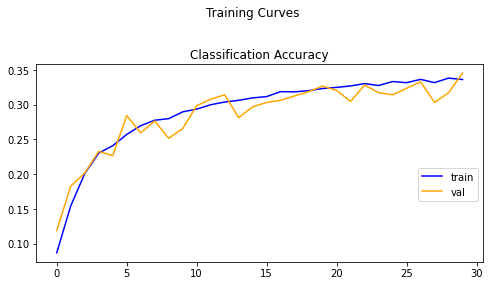


Test set evaluation metrics
10/10 [==============================] - 0s 7ms/step - loss: 2.3995 - accuracy: 0.3203
loss: 2.40
accuracy: 0.32


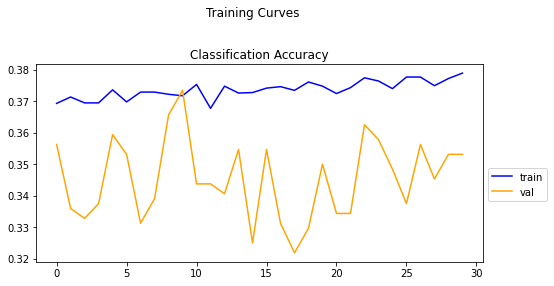


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 2.2795 - accuracy: 0.3617
loss: 2.28
accuracy: 0.36


In [ ]:
# SOFTMAX
model_report(Softmax1, train_Softmax1, 10)
model_report(Softmax2, train_Softmax2, 10)

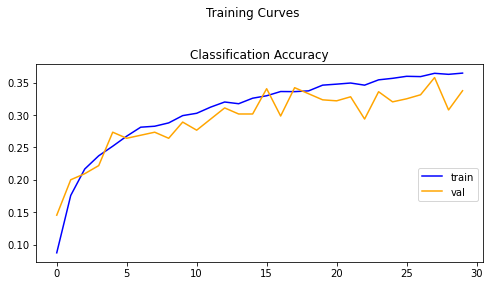


Test set evaluation metrics
100/100 [==============================] - 1s 13ms/step - loss: 2.2792 - accuracy: 0.3520
loss: 2.28
accuracy: 0.35


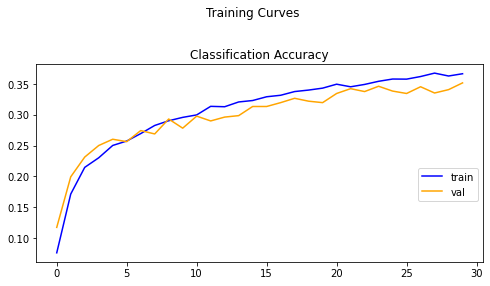


Test set evaluation metrics
100/100 [==============================] - 1s 13ms/step - loss: 2.2705 - accuracy: 0.3459
loss: 2.27
accuracy: 0.35


In [ ]:
model_report(MLP1,train_MLP1,100)
model_report(MLP2,train_MLP2,100)

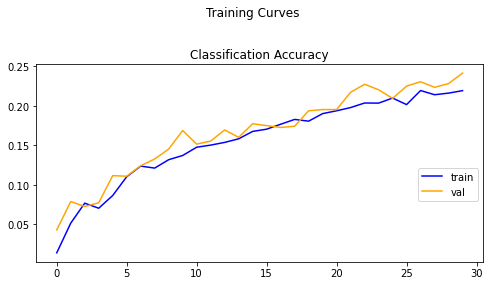


Test set evaluation metrics
100/100 [==============================] - 4s 38ms/step - loss: 2.6509 - accuracy: 0.2223
loss: 2.65
accuracy: 0.22


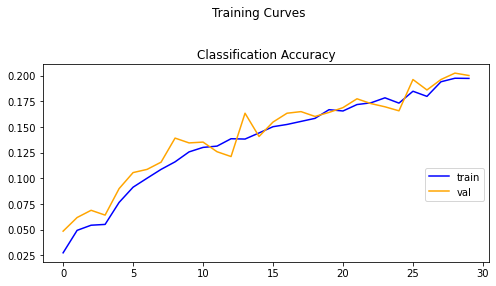


Test set evaluation metrics
100/100 [==============================] - 4s 38ms/step - loss: 2.7437 - accuracy: 0.1864
loss: 2.74
accuracy: 0.19


In [ ]:
model_report(Lenet1,train_Lenet1,100)
model_report(LeNet2,train_LeNet2,100)

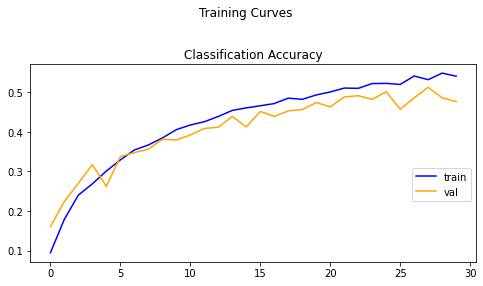


Test set evaluation metrics
100/100 [==============================] - 3s 30ms/step - loss: 1.7923 - accuracy: 0.4682
loss: 1.79
accuracy: 0.47


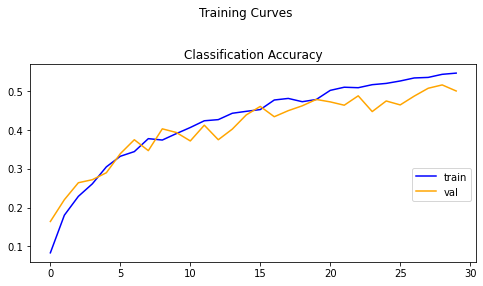


Test set evaluation metrics
100/100 [==============================] - 3s 30ms/step - loss: 1.7153 - accuracy: 0.4891
loss: 1.72
accuracy: 0.49


In [ ]:
model_report(CNN1,train_CNN1,100)
model_report(CNN2,train_CNN2,100)

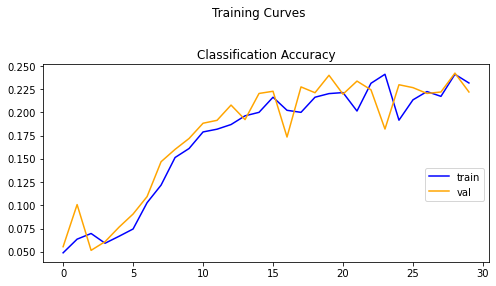


Test set evaluation metrics
100/100 [==============================] - 4s 45ms/step - loss: 4.0185 - accuracy: 0.2205
loss: 4.02
accuracy: 0.22


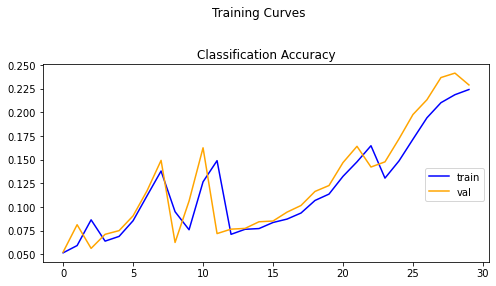


Test set evaluation metrics
100/100 [==============================] - 4s 45ms/step - loss: 3.3326 - accuracy: 0.2236
loss: 3.33
accuracy: 0.22


In [ ]:
model_report(MYCNN1,train_MYCNN1,100)
model_report(MYCNN2,train_MYCNN2,100)

In [ ]:
# παρατηρούμε με βάση το accuracy ότι τα 5 καλύτερα μοντέλα είναι 
# τα εξής

Softamax=train_Softmax2
MLP=train_MLP1
Lenet=train_Lenet1
CNN1=train_CNN2
CNN2=train_MYCNN1

**Αξιολόγηση αποτελεσμάτων που προέκυψαν ως προς:**


**Επίδραση του πλήθους των δεδομένων/κλάσεων στην απόδοση του μοντέλου:** Για να επιτύχουμε βέλτιστο accuracy  σε καθένα απο τα παραπάνω μοντέλα πρέπει να έχουμε 1000 εικόνες ανά κλάση. Επειδή στα δικάς μοντέλα δεν ισχύει κατι τέτοιο είναι λογικό να υπάρχουν αστοχίες

**Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer).** Με εξάιρεση κάποιων μοντέλων (στα οποία η διαφορά δεν ήταν και ιδιαίτερα αισθητή) o optimizer Adam μας έδωσε καλύτερα αποτελέσματα από τον  Adagrad.
(εξάλλου ο Adam συνδιάζει στοιχεία του RMSProp και του Adagrad)

**Επίδραση του μεγέθους δέσμης (batch size).** Επιλέξαμε σχετικά μικρό batch size για καλύτερα αποτελέσματα

**Προσοχή** 

Για τα επόμενα ερωτήματα κρατήσαμε το μοντέλο που αντιστοιχεί στον καλύτερο συνδυασμό ( optimizer, loss, metrics και epoch) από τα μοντέλα που εκπαιδεύσαμε (και για τα 5 μοντέλα - όπως στο Ερώτημα 1, βήμα 2.2).

## Ερώτημα 2

### Βήμα 1: Έλεγχος υπερεκπαίδευσης

Δοκιμάζουμε διάφορους τρόπους για τον έλεγχο της υπερεκπαίδευσης (overfitting), όπως:

- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)

- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)

- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

### Βήμα 2
Αξιολογήστε την ακρίβεια για το validation και το test set σας.

In [ ]:
#Ερώτημα 2
#Βήμα 1: Έλεγχος υπερεκπαίδευσης
#1.1 Δοκιμή τεχνικών για την αντιμετώπιση του προβλήματος της υπερεκπαίδευσης

#Early stopping
#Softmax
#Καλύτερα αποτελέσματα στο Ερώτημα 1 είχε η Version 2
from tensorflow.keras.callbacks import EarlyStopping
#Ορισμός εκ νέου της συνάρτησης με την προσθήκη του Early Stopping
def Softmax_es(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  #Καθορισμός παραμέτρων Early Stopping
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=4, restore_best_weights=True)
  #Eκπαίσευση του μοντέλου
  model.fit(train_ds, callbacks=[es], epochs=30, steps_per_epoch=100, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
Softmaxes=Softmax_es(True)

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_96 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_124 (Dense)            (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 1s 13ms/step - loss: 3.6171 - accuracy: 0.0747 - val_loss: 3.1003 - val_accuracy: 0.1281
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 2.9807 - accuracy: 0.1534 - val_loss: 2.8928 - val_accuracy: 0.2000
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 2.8309 - accuracy: 0.1966 - val_loss: 2.7911 - val_accuracy: 0.2250
Epoch 4/30
100/100 [==============================] - 1s 13ms/step - loss: 2.748

In [ ]:
#MLP
#Version1
def MLP_es(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=4, restore_best_weights=True)
  model.fit(train_ds, callbacks=[es], epochs=30, steps_per_epoch=100, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
MLPes=MLP_es(True)

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_98 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_127 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_128 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 3s 28ms/step - loss: 2.7470 - accuracy: 0.2280 - val_loss: 2.3778 - val_accuracy: 0.3141
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 2.3113 - accuracy: 0.3169 - val_loss: 2.3780 - val_accuracy: 0.3063
Epoch 3/30
100/100 [==============================] - 3s 27ms/step - loss: 2.1800 - acc

In [ ]:
#LeNet
#Version1

def LeNet_es(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=3, restore_best_weights=True)
  model.fit(train_ds, callbacks=[es], epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10)
  return model



In [ ]:
LeNetes=LeNet_es(True)

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_105 (Flatten)        (None, 1152)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 512)               590336    
_________________________________________________________________
dense_138 (Dense)            (None, 200)            

In [ ]:
#CNN
#Version2
def CNN_es(summary):
    
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=4, restore_best_weights=True)
  model.fit(train_ds, callbacks=[es], epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10)    
  return model

In [ ]:
CNNes=CNN_es(True)

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_108 (Flatten)        (None, 512)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 200)            

In [ ]:
#MYCNN
#Version1

def MYCNN_es(summary):
   model = models.Sequential()
   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.Flatten())
   model.add(layers.Dense(100,activation='relu'))
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])    
   if summary: 
    model.summary()
   es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='auto', verbose=1, patience=2, restore_best_weights=True)
   model.fit(train_ds, callbacks=[es], epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10) 
   return model


In [ ]:
MYCNNes = MYCNN_es(True)

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_243 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_155 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_193 (Dense)            (None, 100)            

In [ ]:
#Dropout
from tensorflow.keras.layers import Dropout
#Softmax
#Version2
#Ορισμός της συνάρτησης εκ νέου με την προσθήκη του Dropout Layer
def Softmax_d(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200,activation='softmax'))
  #Προσθήκη του Dropout Layer
  model.add(Dropout(0.1))
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  model.fit(train_ds, epochs=30, steps_per_epoch=100, validation_data=validation_ds, validation_steps=5)
  return model


In [ ]:
Softmaxd=Softmax_d(True)

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_112 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_145 (Dense)            (None, 200)               614600    
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 1s 15ms/step - loss: 4.8245 - accuracy: 0.0680 - val_loss: 3.1417 - val_accuracy: 0.1156
Epoch 2/30
100/100 [==============================] - 1s 15ms/step - loss: 4.2746 - accuracy: 0.1436 - val_loss: 2.9045 - val_accuracy: 0.1922
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 4.0725 - accura

In [ ]:
#MLP
#Version1
def MLP_d(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512,activation='relu'))
  model.add(Dropout(0.2))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  model.fit(train_ds, epochs=30, steps_per_epoch=100, validation_data=validation_ds, validation_steps=5)
  return model

In [ ]:
MLPd=MLP_d(True)

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_113 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_146 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 3s 29ms/step - loss: 2.8879 - accuracy: 0.1843 - val_loss: 2.4855 - val_accuracy: 0.2484
Epoch 2/30
100/100 [==============================] - 3s 29ms/step - loss: 2.3896 - accuracy: 0.2

In [ ]:
#LeNet
#Version1

def LeNet_d(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  model.fit(train_ds, epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10)
  return model


In [ ]:
LeNetd=LeNet_d(True)

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_114 (Flatten)        (None, 1152)           

In [ ]:
#CNN1
#Version2
def CNN_d(summary):
    
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  model.fit(train_ds, epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10)    
  return model

In [ ]:
CNNd=CNN_d(True)

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 4, 4, 32)       

In [ ]:
#MYCNN
#Version2

def MYCNN_d(summary):
   model = models.Sequential()
   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(Dropout(0.1))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.Flatten())
   model.add(layers.Dense(100,activation='relu'))
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])    
   if summary: 
    model.summary()
   model.fit(train_ds, epochs=30, steps_per_epoch=50, validation_data=validation_ds, validation_steps=10) 
   return model

In [ ]:
MYCNNd=MYCNN_d(True)

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_207 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_143 (Flatten)        (None, 1024)           

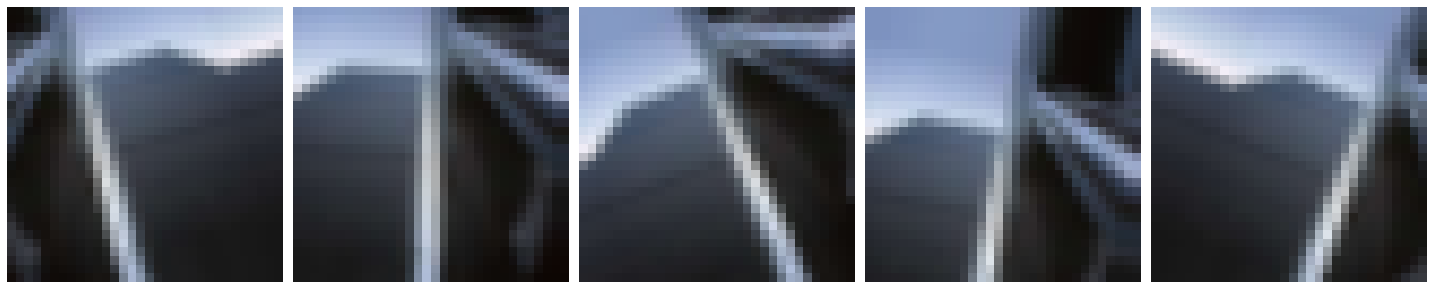

In [ ]:
#Data Augmentation
#Λόγω των αλλαγών που πραγματοποιήσαμε στον βοηθητικό κώδικα στο κομμάτι των TFRecords, εμφανιζόταν ένα error κατα την εκτέλεση
#του κώδικα το οποίο δεν μπορέσαμε να προσδιορίσουμε και να διορθώσουμε. Έτσι, γι' αυτό το υποερώτημα της εργασίας θα χρησιμοποιήσουμε
#τον αρχικό κώδικα της εκφώνησης για TFRecords.
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))

train_data = train.shuffle(data_size).repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_data = train.shuffle(data_size).repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test.shuffle(data_size).repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Συνάρτηση εμφάνισης των εικόνων
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
#Καθορισμός παραμέτρων και τιμών για τις επιπλέον εικόνες που θα παραχθούν από τον generator
image_gen = ImageDataGenerator(
                  rotation_range=45,
                  width_shift_range=.20,
                  height_shift_range=.20,
                  horizontal_flip=True,
                  )
#Καθορισμός παραμέτρων εκπαίδευσης με βάση τα νέα δεδομένα
#Με βάση το train_image_gen θα γίνει αργότερα η εκπαίδευση των μοντέλων μας
train_image_gen=image_gen.flow(
    x=x_train.copy(), y=y_train.copy(), batch_size=BATCH_SIZE, shuffle=True
)

augmented_images = [train_image_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

train_image_gen = train.shuffle(data_size).repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
#Λόγω των αλλαγών στον κώδικα του TFRecords, δημιουργούμε μία δεύτερη συνάρτηση για την εκπαίδευση του μοντελου στην οποία
#έχουν αλλάξει κάποια ονόματα μεταβλητών
def train_model_2(model, epochs, steps_per_epoch, validation_steps, callback=[],train_d=train_data,val_d=val_data):
  history = model.fit(train_d, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=val_d, validation_steps=validation_steps)
  return(history)

In [ ]:
#Softmax
def Softmax_da(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200,activation='softmax'))
  model.add(Dropout(0.1))
  model.compile(optimizer=tf.optimizers.Adagrad(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  return model

In [ ]:
Softmaxda=Softmax_da(True)

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_123 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_158 (Dense)            (None, 200)               614600    
_________________________________________________________________
dropout_41 (Dropout)         (None, 200)               0         
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Εκπαίδευση με προσθήκη της παραμέτρου train_image_gen
Softmax_da_train = train_model_2(Softmaxda, 30, 100, 5, train_image_gen)

Epoch 1/30
100/100 [==============================] - 2s 16ms/step - loss: 3.5805 - accuracy: 0.3109 - val_loss: 2.3036 - val_accuracy: 0.3578
Epoch 2/30
100/100 [==============================] - 2s 18ms/step - loss: 3.6050 - accuracy: 0.3138 - val_loss: 2.3058 - val_accuracy: 0.3391
Epoch 3/30
100/100 [==============================] - 2s 15ms/step - loss: 3.6408 - accuracy: 0.3073 - val_loss: 2.3561 - val_accuracy: 0.3172
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 3.6081 - accuracy: 0.3149 - val_loss: 2.3903 - val_accuracy: 0.3406
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 3.5861 - accuracy: 0.3127 - val_loss: 2.3255 - val_accuracy: 0.3516
Epoch 6/30
100/100 [==============================] - 2s 17ms/step - loss: 3.6199 - accuracy: 0.3164 - val_loss: 2.3375 - val_accuracy: 0.3313
Epoch 7/30
100/100 [==============================] - 2s 16ms/step - loss: 3.5127 - accuracy: 0.3161 - val_loss: 2.3102 - val_accuracy: 0.3375

In [ ]:
#MLP
def MLP_da(summary):
  model = models.Sequential()
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])  
  if summary: 
    model.summary()
  return model

In [ ]:
MLPda=MLP_da(True)

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_124 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_159 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_160 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MLP_da_train = train_model_2(MLPda, 30, 100, 5, train_image_gen)

Epoch 1/30
100/100 [==============================] - 3s 29ms/step - loss: 2.7827 - accuracy: 0.2141 - val_loss: 2.4374 - val_accuracy: 0.2656
Epoch 2/30
100/100 [==============================] - 3s 29ms/step - loss: 2.3349 - accuracy: 0.3077 - val_loss: 2.1995 - val_accuracy: 0.3375
Epoch 3/30
100/100 [==============================] - 3s 28ms/step - loss: 2.2201 - accuracy: 0.3445 - val_loss: 2.0292 - val_accuracy: 0.3766
Epoch 4/30
100/100 [==============================] - 3s 29ms/step - loss: 2.1147 - accuracy: 0.3723 - val_loss: 2.0214 - val_accuracy: 0.3922
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 2.0185 - accuracy: 0.4029 - val_loss: 1.9296 - val_accuracy: 0.4375
Epoch 6/30
100/100 [==============================] - 3s 29ms/step - loss: 1.9744 - accuracy: 0.4126 - val_loss: 1.9798 - val_accuracy: 0.3953
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 1.8969 - accuracy: 0.4341 - val_loss: 1.8173 - val_accuracy: 0.4609

In [ ]:
#LeNet
def LeNet_da(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
LeNetda=LeNet_da(True)

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_126 (Flatten)        (None, 1152)              0         
_________________________________________________________________
dense_163 (Dense)            (None, 512)               590336    
_________________________________________________________________
dense_164 (Dense)            (None, 200)            

In [ ]:
LeNet_da_train = train_model_2(LeNetda, 30, 50, 10, train_image_gen)

Epoch 1/30
50/50 [==============================] - 6s 130ms/step - loss: 3.0508 - accuracy: 0.1369 - val_loss: 2.5867 - val_accuracy: 0.2016
Epoch 2/30
50/50 [==============================] - 7s 132ms/step - loss: 2.4164 - accuracy: 0.2848 - val_loss: 2.1994 - val_accuracy: 0.3578
Epoch 3/30
50/50 [==============================] - 7s 132ms/step - loss: 2.1328 - accuracy: 0.3742 - val_loss: 2.0481 - val_accuracy: 0.4172
Epoch 4/30
50/50 [==============================] - 7s 133ms/step - loss: 1.9524 - accuracy: 0.4273 - val_loss: 1.8118 - val_accuracy: 0.4625
Epoch 5/30
50/50 [==============================] - 7s 133ms/step - loss: 1.8066 - accuracy: 0.4700 - val_loss: 1.7765 - val_accuracy: 0.4734
Epoch 6/30
50/50 [==============================] - 7s 134ms/step - loss: 1.6954 - accuracy: 0.4950 - val_loss: 1.7193 - val_accuracy: 0.4852
Epoch 7/30
50/50 [==============================] - 7s 134ms/step - loss: 1.6349 - accuracy: 0.5053 - val_loss: 1.5793 - val_accuracy: 0.5203
Epoch 

In [ ]:
#CNN1
def CNN_da(summary):
    
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(200,activation='softmax'))
  model.compile(optimizer=tf.optimizers.RMSprop(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
CNNda=CNN_da(True)

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_127 (Flatten)        (None, 512)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 200)            

In [ ]:
CNN_da_train = train_model_2(CNNda, 30, 50, 10, train_image_gen)

Epoch 1/30
50/50 [==============================] - 5s 98ms/step - loss: 3.1402 - accuracy: 0.0737 - val_loss: 2.9280 - val_accuracy: 0.0883
Epoch 2/30
50/50 [==============================] - 5s 97ms/step - loss: 2.7929 - accuracy: 0.1480 - val_loss: 2.6863 - val_accuracy: 0.1758
Epoch 3/30
50/50 [==============================] - 5s 96ms/step - loss: 2.6134 - accuracy: 0.2141 - val_loss: 2.5125 - val_accuracy: 0.2617
Epoch 4/30
50/50 [==============================] - 5s 97ms/step - loss: 2.4967 - accuracy: 0.2527 - val_loss: 2.4082 - val_accuracy: 0.2711
Epoch 5/30
50/50 [==============================] - 5s 96ms/step - loss: 2.3888 - accuracy: 0.2920 - val_loss: 2.2935 - val_accuracy: 0.3469
Epoch 6/30
50/50 [==============================] - 5s 98ms/step - loss: 2.3156 - accuracy: 0.3113 - val_loss: 2.5036 - val_accuracy: 0.2461
Epoch 7/30
50/50 [==============================] - 5s 97ms/step - loss: 2.2547 - accuracy: 0.3339 - val_loss: 2.2829 - val_accuracy: 0.2953
Epoch 8/30
50

In [ ]:
#MYCNN
def MYCNN_da(summary):
   model = models.Sequential()
   model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.MaxPooling2D((2, 2)))
   model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(32, 32, 3)))
   model.add(layers.Flatten())
   model.add(layers.Dense(100,activation='relu'))
   model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])    
   if summary: 
    model.summary()
   return model

In [ ]:
MYCNNda=MYCNN_da(True)

Model: "sequential_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_246 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_156 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_194 (Dense)            (None, 100)            

In [ ]:
MYCNN_da_train = train_model_2(MYCNNda, 30, 50, 10, train_image_gen)

Epoch 1/30
50/50 [==============================] - 7s 149ms/step - loss: 8.1018 - accuracy: 0.0525 - val_loss: 12.8374 - val_accuracy: 0.0531
Epoch 2/30
50/50 [==============================] - 8s 150ms/step - loss: 9.9493 - accuracy: 0.0598 - val_loss: 8.6533 - val_accuracy: 0.1008
Epoch 3/30
50/50 [==============================] - 7s 148ms/step - loss: 5.9796 - accuracy: 0.0275 - val_loss: 4.6052 - val_accuracy: 0.0000e+00
Epoch 4/30
50/50 [==============================] - 7s 148ms/step - loss: 4.6052 - accuracy: 0.0000e+00 - val_loss: 4.6052 - val_accuracy: 0.0000e+00
Epoch 5/30
50/50 [==============================] - 7s 145ms/step - loss: 4.6052 - accuracy: 0.0000e+00 - val_loss: 4.6052 - val_accuracy: 0.0000e+00
Epoch 6/30
50/50 [==============================] - 7s 148ms/step - loss: 4.6052 - accuracy: 0.0000e+00 - val_loss: 4.6052 - val_accuracy: 0.0000e+00
Epoch 7/30
50/50 [==============================] - 7s 148ms/step - loss: 4.6052 - accuracy: 0.0000e+00 - val_loss: 4.6

Αρχικά, θα πρέπει να εξηγήσουμε τι κάνει καθεμία από τις τεχνικές ελέγχου υπερεκπαίδευσης που χρησιμοποιήσαμε.

**1. Early Stopping**

Πρόκειται για μία τεχνική η οποία τερματίζει πρόωρα την εκπαίδευση, κρατόντας κάθε φορά την τελευταία τιμή μίας μεταβήτής που ορίζουμε εμείς και συγκρίνοντας την με τις επόμενες τιμές της, ούτως ώστε να μην επιτρέψει στην εκπαίδευση να προχωρήσει παρακάτω, όταν αυτή χειροτερεύει. Χρησιμοποιήσαμε τις εξής παραμέτρους:

*   monitor: ποια μεταβλητή θα "παρακολουθεί" το Early Stopping. Εδώ επιλέχθηκε το 'val_loss' 
*   min_delta: ποια είναι η ελάχιστη μεταβολή σε μία μεταβλητή ώστε να θεωρούμε ότι εκείνη έχει μεταβληθεί
*   mode: καθορίζει αν θέλουμε η μεταβλητή που επιλέχθηκε στο monitor πρέπει να αυξάνεται ή να μειώνεται. Επιλέξαμε το 'auto', δηλαδή να διαλέγει αυτόματα αναλόγως με την μεταβλητή που βάλαμε
*   verbose: λειτουργία verbosity
*   patience: πόσες εποχές πρέπει να περιμένει και να παρακολουθέι την μεταβλητή έως ότου τερματίσει
*   restore_best_weights: αν θα αποθηκεύει ή όχι την καλύτερη τιμή όταν τερματίζει. Το θέσαμε 'true'

Επομένως με το Early Stopping παρακολουθούσαμε την μεταβλητή 'val_loss' και όταν αυτή αυξανόταν, περιμένοντας τόσες εποχές όσες είχαμε ορίσει, τερματίζαμε την εκπαίδευση του μοντέλου ώστε να μην αυξηθεί πολύ, μειώνοντας την ακρίβεια του μοντέλου μας.

**2.Dropout**

Η τεχνική Dropout λειτουργεί με πιθανή αφαίρεση, ή "απόρριψη" εισόδων σε ένα επίπεδο, οι οποίες μπορεί να είναι μεταβλητές εισόδου στο δείγμα δεδομένων ή ενεργοποιήσεις από ένα προηγούμενο επίπεδο. Έχει ως αποτέλεσμα την προσομοίωση μεγάλου αριθμού δικτύων με πολύ διαφορετική δομή, καθιστώντας τους κόμβους στο δίκτυο γενικά πιο ισχυρούς στις εισόδους. Ουσιαστικά, πρόκειται για ένα layer που, όπως αναφέρει και η εκφώνηση, μηδενίζει τυχαία κάποια βάρη με αποτέλεσμα να ομαλοποιείται το σύνολο εκπαίδευσης, να αποφέυγονται οι ανεπιθύμητες είσοδοι και να μειώνεται τελικά η υπερεκπαίδευση. 
Δέχεται μία παράμετρο η οποία καθορίζει το ποσοστό που θέλουμε να εφαρμοστεί η τεχνική αυτή.

**3. Data Augementation**

Το Data Augmentation αποτελέι μία τεχνική η οποία αυξάνει το σύνολο δεδομένων εκπαίδευσης, καθώς αυτό πολλές φορές δεν είναι επαρκές. Αυτό βέβαια δεν επιτυγχάνεται με την προσθήκη νέων εικόνων, αλλά με την κατάλληλη επεξεργασία των ήδη υπάρχοντων. Ουσιαστικά παίρνει τις εικόνες του dataset και τις τροποποιεί ως προς διάφορα χαρακτηριστικά όπως η κλίση, η μεγέθυνση, ο προσανατολισμός κ.α. Με αυτόν τον τρόπο το μοντέλο μας λαμβάνει μία πιο άρτια εκπαίδευση.

**Συμπεράσματα μετρήσεων**

Όπως φαίνεται και από την εκτέλεση των παραπάνω τεχνικών, αυτές όντως συνέβαλαν σημαντικά στην βελτίωση της απόδοσης κάποιων μοντέλων, με τον περιορισμό της υπερεκπαίδευσης τους. Πιο συγκεκριμένα, ενώ κάποια μοντέλα φαίνεται να μην ωφελήθηκαν από καμία τεχνική (όπως το Softmax και το MYCNN), κάποια άλλα παρουσίασαν θεαματική βελτίωση τόσο στο train set όσο και στο val set (όπως το LeNet που απο 0,22 απέκτησε απόδοση 0,7-0,8 και από τις 3 μεθόδους). 
Παράλληλα παρατηρούμε ότι η ακρίβεια του validation κυμένται κατά κύριο λόγο σε όμοιες τιμές με εκείνες του test, πέρα κάποιων εξαιρέσεων που είναι μικρότερη, γεγονός που μας δείχνει ότι τα μοντέλα κάνουν σωστή αξιολόγηση.
Τέλος, στην πλειονότητα των εκπαιδέυσεων των μοντέλων με τη χρήση των παραπάνω τεχνικών, παρατηρήθηκε γενικά μία μεγαλύτερη ομαλότητα των τιμών σε σχέση με πριν που, όπως φαίνεται και από τα διαγράμματα, υπάρχουν κάποιες απότομες μεταβάσεις και διακυμάνσεις.

**Σημείωση:** Οι τιμές των παραμέτρων των διάφορων μεθόδων προέκυψαν έπειτα από πολλές δοκιμές και επιλέχθηκαν εκείνες οι οποίες μας έδιναν τα βέλτιστα αποτελέσματα για κάθε μοντέλο.
Στο MYCNN είχαν προκύψει αρχικά καλύτερα αποτελέσματα αλλά σε μετέπειτα εκτελέσεις, ενώ ο κώδικας παρέμεινε αμετάβλητος, η απόδοση μειώθηκε αρκετά. Δεν μπορέσαμε να εντοπίσουμε για ποιο λόγο έγινε αυτό.









